In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

#### Load data (days -2 to 1)

In [3]:
DIR = "data/round-2/"

In [4]:
price = pd.read_csv(DIR+"price_history.csv", delimiter=';')

In [5]:
TIME = price["timestamp"].unique()

### Round 2 strategy

### SPREAD

In [6]:
KELP = price.loc[price["product"]=="KELP"].reset_index(drop=True)
SQUID = price.loc[price["product"]=="SQUID_INK"].reset_index(drop=True)
CROSS = price.loc[price["product"]=="CROISSANTS"].reset_index(drop=True)
JAM = price.loc[price["product"]=="JAMS"].reset_index(drop=True)
DJ = price.loc[price["product"]=="DJEMBES"].reset_index(drop=True)
PB1 = price.loc[price["product"]=="PICNIC_BASKET1"].reset_index(drop=True)
PB2 = price.loc[price["product"]=="PICNIC_BASKET2"].reset_index(drop=True)

In [7]:
def get_swmp(df):
    """
    get size-weighted midprice (SWMP)
    """
    swmp = []
    for _, row in df.iterrows():
        best_ask, ask_vol = row["ask_price_1"], row["ask_volume_1"]
        best_bid, bid_vol = row["bid_price_1"], row["bid_volume_1"]
        swmp.append((best_bid * ask_vol + best_ask * bid_vol) / (bid_vol + ask_vol))
    
    return swmp


In [8]:
swmp_implied1 = []
for (_, row1), (_, row2), (_, row3) in zip(CROSS.iterrows(), JAM.iterrows(), DJ.iterrows()):

    implied_bid = 6 * row1["bid_price_1"] + 3 * row2["bid_price_1"] + row3["bid_price_1"]
    implied_ask = 6 * row1["ask_price_1"] + 3 * row2["ask_price_1"] + row3["ask_price_1"]
    implied_ask_vol = min([row1["ask_volume_1"] // 6, row2["ask_volume_1"] // 3, row3["ask_volume_1"]])
    implied_bid_vol = min([row1["bid_volume_1"] // 6, row2["bid_volume_1"] // 3, row3["bid_volume_1"]])
    swmp_implied1.append((implied_bid * implied_ask_vol + implied_ask * implied_bid_vol) / (implied_bid_vol + implied_ask_vol))

In [9]:
swmp_implied2 = []
for (_, row1), (_, row2) in zip(CROSS.iterrows(), JAM.iterrows()):

    implied_bid = 4 * row1["bid_price_1"] + 2 * row2["bid_price_1"] 
    implied_ask = 4 * row1["ask_price_1"] + 2 * row2["ask_price_1"]
    implied_ask_vol = min([row1["ask_volume_1"] // 4, row2["ask_volume_1"] // 2])
    implied_bid_vol = min([row1["bid_volume_1"] // 2, row2["bid_volume_1"] // 2])
    swmp_implied2.append((implied_bid * implied_ask_vol + implied_ask * implied_bid_vol) / (implied_bid_vol + implied_ask_vol))

In [10]:
swmp_PB1 = np.array(get_swmp(PB1))
swmp_PB2 = np.array(get_swmp(PB2))

In [11]:
SPREAD1 = swmp_PB1 - np.array(swmp_implied1) 

In [12]:
implied1 = 6 * CROSS["mid_price"] + 3 * JAM["mid_price"] + DJ["mid_price"]
implied2 = 4 * CROSS["mid_price"] + 2 * JAM["mid_price"]

In [13]:
SPREAD2 = swmp_PB2 - np.array(swmp_implied2) 

In [14]:
window = 20
mult = 2.5
spread_hist = []
buy, sell = [], []
hits = 1
consecutive = 1
signal = 0

upper, lower = 0, 0
for i, val in enumerate(SPREAD1):
    spread_hist.append(val)
    spread_hist = spread_hist[-window:]
    if len(spread_hist) >= window:
        z = (spread_hist[-1] - np.mean(spread_hist)) / np.std(spread_hist, ddof=1)
        if z >= mult:
            upper += 1
            lower = 0
            if upper >= hits:
                if signal < 0:
                    signal -= 1
                else:
                    signal = -1
                if signal == -1 or signal <= -consecutive:
                    sell.append(i)

                
        elif z <= -mult:
            upper = 0
            lower += 1
            if lower >= hits:
                if signal > 0:
                    signal += 1
                else:
                    signal = 1
                if signal == 1 or signal >= consecutive:
                    buy.append(i)
        

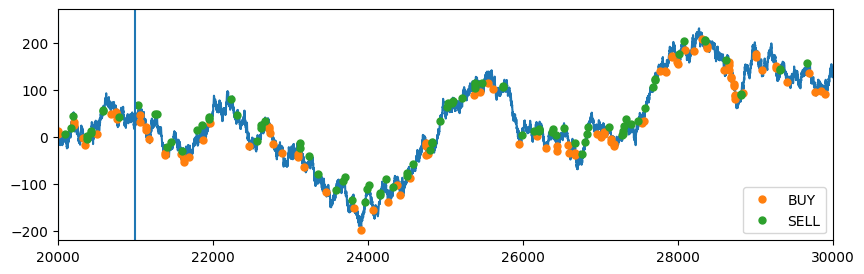

In [15]:
plt.figure(figsize=(10,3))
plt.plot(SPREAD1)
plt.plot(buy, SPREAD1[buy], lw=0, marker='.', ms=10, label="BUY")
plt.plot(sell, SPREAD1[sell], lw=0, marker='.', ms=10, label="SELL")
plt.axvline(20000)
plt.axvline(21000)
plt.xlim((20000, 30000))
plt.legend()


In [18]:
window = 15
mult = 2.5
spread_hist = []
buy, sell = [], []

upper, lower = 0, 0
for i, val in enumerate(SPREAD2):
    spread_hist.append(val)
    spread_hist = spread_hist[-window:]
    if len(spread_hist) >= window:
        z = (spread_hist[-1] - np.mean(spread_hist)) / np.std(spread_hist, ddof=1)
        if z >= mult:
            sell.append(i)

        elif z <= -mult:
            buy.append(i)
        

Signals vs Live performance

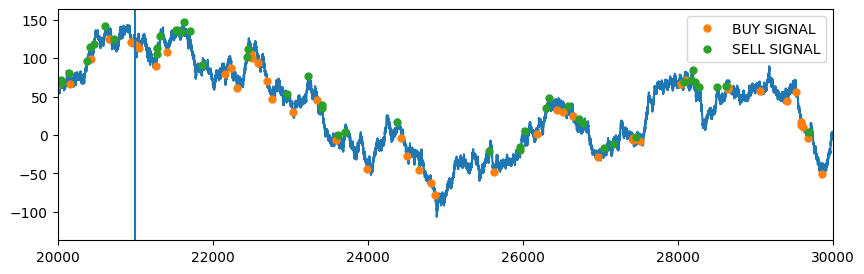

In [19]:
plt.figure(figsize=(10,3))
plt.plot(SPREAD2)
plt.plot(buy, SPREAD2[buy], lw=0, marker='.', ms=10, label="BUY SIGNAL")
plt.plot(sell, SPREAD2[sell], lw=0, marker='.', ms=10, label="SELL SIGNAL")
plt.axvline(21000)
plt.xlim((20000, 30000))
# plt.ylim((0,150))
plt.legend()

(0.0, 1000.0)

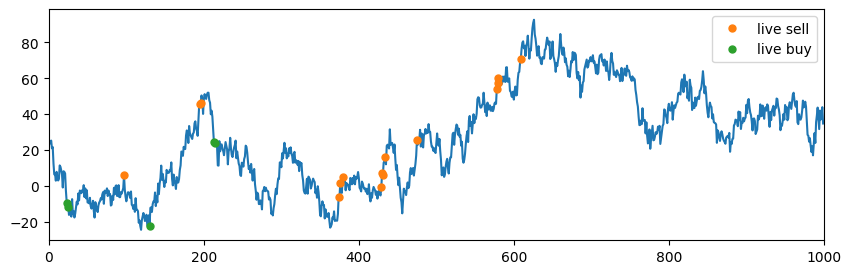

In [20]:
infile = DIR+"basket.log"
hist = get_tradehistory(infile)
pb1_hist = get_mytrades(hist, "PICNIC_BASKET1")
pb1_buy = pb1_hist.loc[pb1_hist["buyer"]=="SUBMISSION"]
pb1_sell = pb1_hist.loc[pb1_hist["seller"]=="SUBMISSION"]
buy_time = pb1_buy["timestamp"].array / 100
sell_time = pb1_sell["timestamp"].array / 100
buy_price = SPREAD1[20000+buy_time.astype(int)]
sell_price = SPREAD1[20000+sell_time.astype(int)]

plt.figure(figsize=(10,3))
plt.plot(TIME[:1000]/100, SPREAD1[20000:21000])
plt.plot(sell_time, sell_price, lw=0, ms=10, marker='.', label="live sell")
plt.plot(buy_time, buy_price, lw=0, ms=10, marker='.', label="live buy")
plt.legend()
plt.xlim((0,1000))

(0.0, 1000.0)

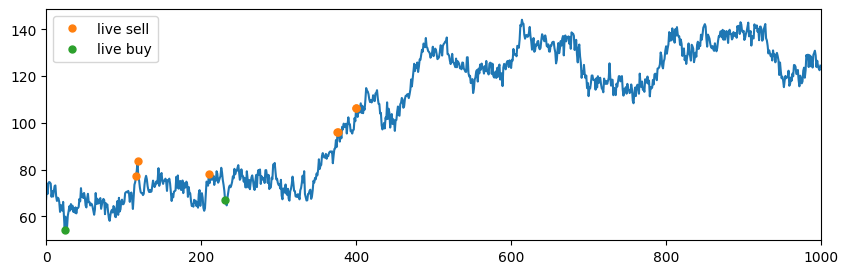

In [21]:
pb2_hist = get_mytrades(hist, "PICNIC_BASKET2")
pb2_buy = pb2_hist.loc[pb2_hist["buyer"]=="SUBMISSION"]
pb2_sell = pb2_hist.loc[pb2_hist["seller"]=="SUBMISSION"]
buy_time = pb2_buy["timestamp"].array / 100
sell_time = pb2_sell["timestamp"].array / 100
buy_price = SPREAD2[20000+buy_time.astype(int)]
sell_price = SPREAD2[20000+sell_time.astype(int)]

plt.figure(figsize=(10,3))
plt.plot(TIME[:1000]/100, SPREAD2[20000:21000])
plt.plot(sell_time, sell_price, lw=0, ms=10, marker='.', label="live sell")
plt.plot(buy_time, buy_price, lw=0, ms=10, marker='.', label="live buy")
plt.legend()
plt.xlim((0,1000))

In [22]:
window = 1000
mult = 1.2
spread_hist = []
buy, sell = [], []

for i, val in enumerate(SPREAD2):
    spread_hist.append(val)
    spread_hist = spread_hist[-window:]
    if len(spread_hist) >= window:
        z = (spread_hist[-1] - np.mean(spread_hist)) / np.std(spread_hist, ddof=1)
        if z >= mult:
            sell.append(i)
        elif z <= -mult:
            buy.append(i)
        

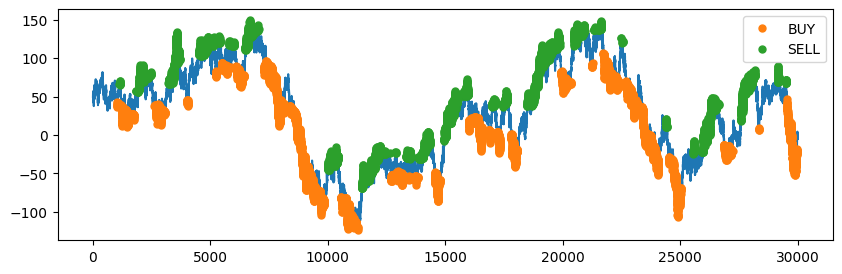

In [23]:
plt.figure(figsize=(10,3))
plt.plot(SPREAD2)
plt.plot(buy, SPREAD2[buy], lw=0, marker='.', ms=10, label="BUY")
plt.plot(sell, SPREAD2[sell], lw=0, marker='.', ms=10, label="SELL")
plt.legend()

#### Linear regression on the individual contents

In [24]:
infile = DIR+"current.log"
hist = get_tradehistory(infile)
prod_hist = get_mytrades(hist, "CROISSANTS")
buy = prod_hist.loc[prod_hist["buyer"]=="SUBMISSION"]
sell = prod_hist.loc[prod_hist["seller"]=="SUBMISSION"]
buy_time = buy["timestamp"].array / 100
sell_time = sell["timestamp"].array / 100
buy_price = CROSS["mid_price"].array[20000+buy_time.astype(int)]
sell_price = CROSS["mid_price"].array[20000+sell_time.astype(int)]

plt.figure(figsize=(10,3))
plt.plot(TIME[:1000]/100, CROSS["mid_price"].array[20000:21000])
plt.plot(sell_time, sell_price, lw=0, ms=10, marker='.', label="live sell")
plt.plot(buy_time, buy_price, lw=0, ms=10, marker='.', label="live buy")
plt.legend()
plt.xlim((0,1000))

FileNotFoundError: [Errno 2] No such file or directory: 'data/round-2/current.log'

<Figure size 1000x300 with 0 Axes>

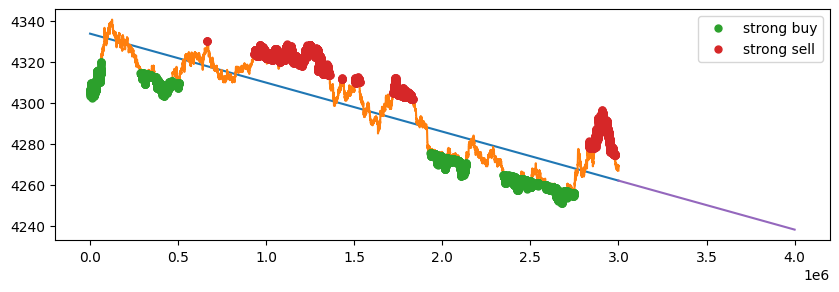

In [25]:
plt.figure(figsize=(10,3))
y = CROSS["mid_price"].array
X = np.arange(0, 100 * len(y), 100)

A = np.vstack([X, np.ones(len(y))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
sigma = np.std(y)

strongbuy, strongsell = [], []
mult = 0.5
for i, p in enumerate(y):
    mean = m * i * 100 + c
    if p > mean + mult * sigma:
        strongsell.append(i)
    elif p < mean - mult * sigma:
        strongbuy.append(i)

plt.figure(figsize=(10,3))
plt.plot(X, m * X + c)
plt.plot(X, y)
plt.plot(X[strongbuy], y[strongbuy], lw=0, ms=10, marker='.', label="strong buy")
plt.plot(X[strongsell], y[strongsell], lw=0, ms=10, marker='.', label="strong sell")

c0 = m * (X[-1]+100) + c
plt.plot(range(int(3e6), int(4e6), 100), m * TIME + c0)
plt.legend()

<Figure size 1000x300 with 0 Axes>

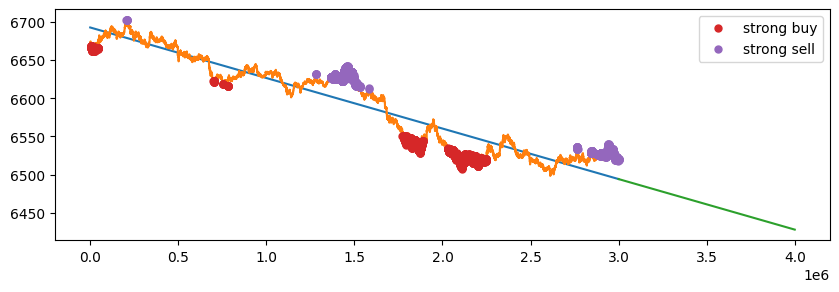

In [86]:
plt.figure(figsize=(10,3))
y = JAM["mid_price"].array
X = np.arange(0, 100 * len(y), 100)

strongbuy, strongsell = [], []
mult = 1.
for i, p in enumerate(y):
    mean = m * i * 100 + c
    if p > mean + mult * sigma:
        strongsell.append(i)
    elif p < mean - mult * sigma:
        strongbuy.append(i)


A = np.vstack([X, np.ones(len(y))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

plt.figure(figsize=(10,3))
plt.plot(X, m * X + c)
plt.plot(X, y)

c0 = m * (X[-1]+100) + c
plt.plot(range(int(3e6), int(4e6), 100), m * TIME + c0)
plt.plot(X[strongbuy], y[strongbuy], lw=0, ms=10, marker='.', label="strong buy")
plt.plot(X[strongsell], y[strongsell], lw=0, ms=10, marker='.', label="strong sell")
plt.legend()

<Figure size 1000x300 with 0 Axes>

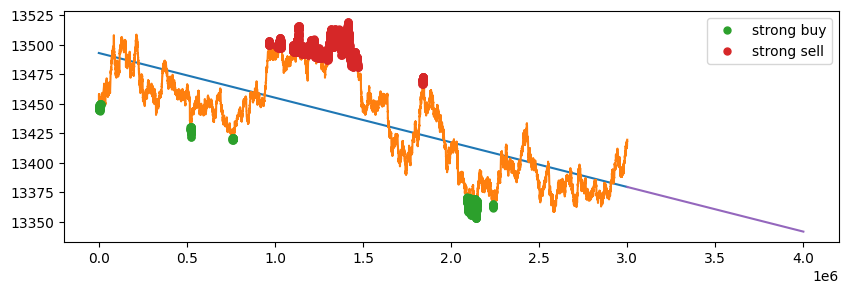

In [96]:
plt.figure(figsize=(10,3))
y = DJ["mid_price"].array
X = np.arange(0, 100 * len(y), 100)

A = np.vstack([X, np.ones(len(y))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
sigma = np.std(y)

strongbuy, strongsell = [], []
mult = 1.
for i, p in enumerate(y):
    mean = m * i * 100 + c
    if p > mean + mult * sigma:
        strongsell.append(i)
    elif p < mean - mult * sigma:
        strongbuy.append(i)

plt.figure(figsize=(10,3))
plt.plot(X, m * X + c)
plt.plot(X, y)
plt.plot(X[strongbuy], y[strongbuy], lw=0, ms=10, marker='.', label="strong buy")
plt.plot(X[strongsell], y[strongsell], lw=0, ms=10, marker='.', label="strong sell")

c0 = m * (X[-1]+100) + c
plt.plot(range(int(3e6), int(4e6), 100), m * TIME + c0)
plt.legend()

Probably not possible to hedge against each other

In [22]:
np.corrcoef(SPREAD1, SQUID.loc[SQUID["day"]>-2]["mid_price"].array)[0][1]

np.float64(-0.1972347201279065)

In [23]:
np.corrcoef(SPREAD2, SQUID.loc[SQUID["day"]>-2]["mid_price"].array)[0][1]

np.float64(0.048452720387722185)

### KELP

Regress over data up to and incl. day 0, then backtest on the day 1 data.

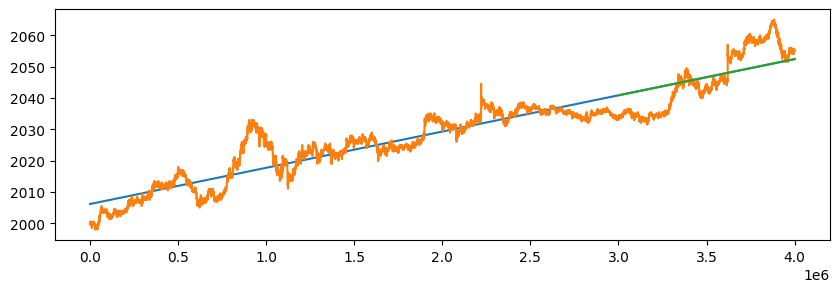

In [306]:
y = KELP["mid_price"].array
X = np.arange(0, 100 * len(y), 100)

split = 30000
X_train = X[:split]
y_train = y[:split]

A = np.vstack([X_train, np.ones(len(y_train))]).T
m, c = np.linalg.lstsq(A, y_train, rcond=None)[0]

plt.figure(figsize=(10,3))
plt.plot(X, m * X + c)
plt.plot(X, y)

# plot portion of day 1
c0 = m * X[split] + c
plt.plot(X[split:], m * TIME + c0)

Now regress over whole history: projection for Day 2 data

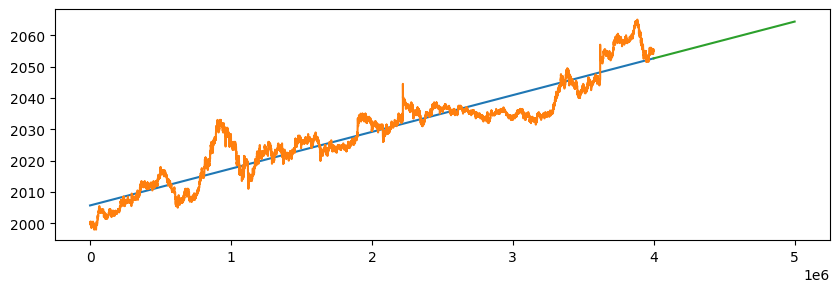

In [315]:
y = KELP["mid_price"].array
X = np.arange(0, 100 * len(y), 100)

A = np.vstack([X, np.ones(len(y))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

plt.figure(figsize=(10,3))
plt.plot(X, m * X + c)
plt.plot(X, y)

c0 = m * (X[-1]+100) + c
plt.plot(range(int(4e6), int(5e6), 100), m * TIME + c0)

In [316]:
sigma = np.std(y)

In [317]:
sigma, m, c0

(np.float64(14.422964389386117),
 np.float64(1.173227183514493e-05),
 np.float64(2052.6409802838834))

In [318]:
strongbuy, strongsell = [], []
mult = 0.5
for i, p in enumerate(y):
    mean = m * i * 100 + c
    if p > mean + mult * sigma:
        strongsell.append(i)
    elif p < mean - mult * sigma:
        strongbuy.append(i)

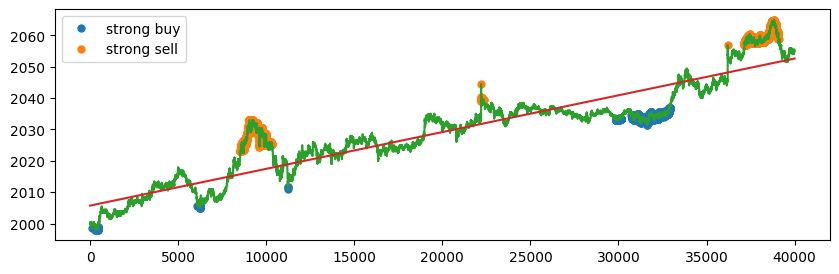

In [319]:
plt.figure(figsize=(10,3))
plt.plot(strongbuy, y[strongbuy], lw=0, ms=10, marker='.', label="strong buy")
plt.plot(strongsell, y[strongsell], lw=0, ms=10, marker='.', label="strong sell")
plt.plot(y)
plt.plot(m * X + c)
plt.legend()

### SQUID

In [26]:
class Z_trader:

    def __init__(self):

        self.squid_hist = []
        self.upper = 0
        self.lower = 0
        self.slow_upper = 0
        self.slow_lower = 0

    def get_signal(self, fairprice, window_fast=20, window_slow=50, mult=1.25, mult_strong=2.5,
                   hits=1, strong_hits=3):
        strong_signal = None
        action = None

        self.squid_hist.append(fairprice)
        self.squid_hist = self.squid_hist[-window_slow:]

        # Mean reversion strategy
        sma_slow = np.mean(np.array(self.squid_hist))
        sma_fast = np.mean(np.array(self.squid_hist[-window_fast:]))
        std_slow = np.std(np.array(self.squid_hist), ddof=1)
        std_fast = np.std(np.array(self.squid_hist[-window_fast:]))
        z_slow = (self.squid_hist[-1] - sma_slow) / std_slow
        z_fast= (self.squid_hist[-1] - sma_fast) / std_fast


        if z_slow <= -mult_strong or z_fast <= -mult_strong:
            strong_signal = "BUY"
            self.lower += 1
            self.upper = 0
        elif z_slow >= mult_strong or z_fast >= mult_strong:
            strong_signal = "SELL"
            self.upper += 1
            self.lower = 0

        else:
            if z_fast < -mult:
                self.lower += 1
                self.upper = 0
            elif z_fast > mult:
                self.lower = 0
                self.upper += 1
            else:
                self.lower = 0
                self.upper = 0
            
            if z_slow < -mult:
                self.slow_lower += 1
                self.slow_upper = 0
            elif z_slow > mult:
                self.slow_upper += 1
                self.slow_lower = 0   
        
            if self.upper >= hits:      # sell 
                action = "SELL"
                self.upper = self.lower = 0

            elif self.lower >= hits:        # buy
                action = "BUY"
                self.upper = self.lower = 0
            
            if self.slow_upper >= strong_hits:      # strong sell
                strong_signal = "SELL"
                self.slow_lower = self.slow_upper = 0
            elif self.slow_lower >= strong_hits:        # strong buy
                strong_signal = "BUY"
                self.slow_lower = self.slow_upper = 0

        return action, strong_signal

In [27]:
Ztrader = Z_trader()
buy, sell, exit, strong_buy, strong_sell = [], [], [], [], []

for i, price in enumerate(list(SQUID["mid_price"])):       
    action, strong = Ztrader.get_signal(price, window_fast=10, window_slow=30, mult=1.2, mult_strong=3.,
                   hits=1, strong_hits=10)
    if action == "BUY":
        buy.append(i)
    elif action == "SELL":
        sell.append(i)
    if strong == "BUY":
        strong_buy.append(i)
    elif strong == "SELL":
        strong_sell.append(i)


/Users/karin/.local/share/virtualenvs/prosperity/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/karin/.local/share/virtualenvs/prosperity/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/tk/w4xllgbs0ds2ch4ngj5_n8280000gn/T/ipykernel_2220/3949440728.py:25: RuntimeWarning: invalid value encountered in scalar divide
  z_fast= (self.squid_hist[-1] - sma_fast) / std_fast


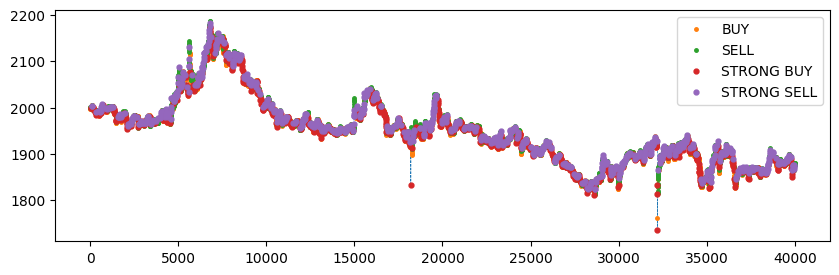

In [30]:
plt.figure(figsize=(10,3))
plt.plot(SQUID["mid_price"].array, lw=0.5, ls='dashed')
plt.plot(buy, SQUID["ask_price_1"].array[buy], lw=0, marker=".", ms=5, label="BUY")
plt.plot(sell, SQUID["bid_price_1"].array[sell], lw=0, marker=".", ms=5, label="SELL")
plt.plot(strong_buy, SQUID["ask_price_1"].array[strong_buy], lw=0, marker=".", ms=7, label="STRONG BUY")
plt.plot(strong_sell, SQUID["bid_price_1"].array[strong_sell], lw=0, marker=".", ms=7, label="STRONG SELL")
# plt.xlim((30000, 31000))
# plt.ylim(1830, 1920)
plt.legend()
plt.show()